# Modeling Confidence using Drift Diffusion Models

We will use the Drift Diffusion Model to model the confidence of a participant. This is done across 3 experiments where drift rate is assumed to reflect the relative confidence. With higher drift rates showing higher confidence and vice-versa. The three experiments are as follows:
 * No feedback: No feedback is provided assuming that the participant will choose more random choices.
 * True values: The participant is shown a correct/wrong choice as feedback, assuming to impact the confidence of the participant in a positive manner.
 * Score: Along with true values, the participant is shown a score as feedback, assuming to impact the confidence of the participant in a negative manner.


## Model Implementation *(3 points)*



In [1]:
!pip install git+https://github.com/lnccbrown/HSSM.git
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
import hssm
import hssm.plotting
hssm.set_floatX("float32")
import arviz as az
import seaborn as sns
import matplotlib.pyplot as plt
# import warnings

# warnings.filterwarnings('ignore')

  Cloning https://github.com/lnccbrown/HSSM.git to /tmp/pip-req-build-ome4719t
  Running command git clone --filter=blob:none --quiet https://github.com/lnccbrown/HSSM.git /tmp/pip-req-build-ome4719t
  Resolved https://github.com/lnccbrown/HSSM.git to commit 19b24538a20938ffc4c8b0bf88ca35d6d51b4196
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
Setting PyTensor floatX type to float32.


INFO:hssm:Setting PyTensor floatX type to float32.


Setting "jax_enable_x64" to False. If this is not intended, please set `jax` to False.


INFO:hssm:Setting "jax_enable_x64" to False. If this is not intended, please set `jax` to False.


In [2]:
"""
Simulating dataset for the first experiment.

Attributes:
v_1 (float): drift rate (assuming to be the midvalue given the condition)
a_1 (float): threshold
z_1 (float): starting point (between 0 and threshold a)
t0_1 (float): non-decision time

"""

v_1 = 0.5              # drift rate
a_1 = 1.0             # threshold
z_1 = 0.5            # starting point (between 0 and threshold a)
t0_1 = 0.1            # non-decision time

true_values = [v_1, a_1, z_1, t0_1]

exp_sim_dataset1 = hssm.simulate_data(
    model="ddm",
    theta=true_values,
    size=150,
)

def cumulative_sum_until_zero(series):
    cum_sum = 0
    cum_sum_list = []
    for value in series:
        if value == 0:
            cum_sum = 0
        else:
            cum_sum += value
        cum_sum_list.append(cum_sum)
    return cum_sum_list

for i in range(len(exp_sim_dataset1)):
  if exp_sim_dataset1.loc[i, 'response'] == 1:
    exp_sim_dataset1.loc[i, 'task_transition'] = np.random.choice([0, 1], p=[0.65, 0.35])
    exp_sim_dataset1.loc[i, 'task_type'] = np.random.choice([0, 1], p=[0.7, 0.3])
    exp_sim_dataset1.loc[i, 'congruency'] = np.random.choice([0, 1], p=[0.7, 0.3])
  else:
    exp_sim_dataset1.loc[i, 'task_transition'] = np.random.choice([1, 0], p=[0.65, 0.35])
    exp_sim_dataset1.loc[i, 'task_type'] = np.random.choice([1, 0], p=[0.7, 0.3])
    exp_sim_dataset1.loc[i, 'congruency'] = np.random.choice([1, 0], p=[0.7, 0.3])

exp_sim_dataset1['task_transition'][exp_sim_dataset1.index == 0] = 2
exp_sim_dataset1['trial_no_exp_type'] = 1
exp_sim_dataset1['trial_no_exp_type'] = exp_sim_dataset1['trial_no_exp_type'].cumsum()
exp_sim_dataset1['win_streak_exp_type'] = exp_sim_dataset1['response'].apply(lambda x: 1 if x == 1 else 0)
exp_sim_dataset1['loss_streak_exp_type'] = exp_sim_dataset1['response'].apply(lambda x: 0 if x == 1 else 1)
exp_sim_dataset1['accuracy_exp_type'] = exp_sim_dataset1['win_streak_exp_type'].cumsum()

exp_sim_dataset1['win_streak_exp_type'] = cumulative_sum_until_zero(exp_sim_dataset1['win_streak_exp_type'])
exp_sim_dataset1['loss_streak_exp_type'] = cumulative_sum_until_zero(exp_sim_dataset1['loss_streak_exp_type'])

exp_sim_dataset1['accuracy_exp_type'] = exp_sim_dataset1['accuracy_exp_type']/exp_sim_dataset1['trial_no_exp_type']
exp_sim_dataset1['accuracy_exp_type'] = exp_sim_dataset1['accuracy_exp_type'].round(2)
exp_sim_dataset1

,rt,response,task_transition,task_type,congruency,trial_no_exp_type,win_streak_exp_type,loss_streak_exp_type,accuracy_exp_type
0,0.358929,1.0,2.0,1.0,0.0,1,1,0,1.00
1,0.570582,1.0,0.0,0.0,0.0,2,2,0,1.00
2,0.364555,1.0,1.0,0.0,0.0,3,3,0,1.00
3,1.034609,1.0,1.0,0.0,0.0,4,4,0,1.00
4,0.740141,-1.0,1.0,1.0,1.0,5,0,1,0.80
...,...,...,...,...,...,...,...,...,...
145,1.290862,-1.0,0.0,1.0,1.0,146,0,1,0.75
146,2.865627,1.0,0.0,1.0,0.0,147,1,0,0.75
147,2.297896,1.0,1.0,0.0,1.0,148,2,0,0.75
148,1.133105,1.0,0.0,1.0,0.0,149,3,0,0.75


In [3]:
"""
    Simulating dataset for the second experiment.

    Attributes:
    v_2 (float): drift rate (assuming to be the higher given the condition)
    a_2 (float): threshold
    z_2 (float): starting point (between 0 and threshold a)
    t0_2 (float): non-decision time

"""

v_2= 0.7            # drift rate
a_2= 1.0             # threshold
z_2= 0.5            # starting point (between 0 and threshold a)
t0_2 = 0.1            # non-decision time

true_values = [v_2, a_2, z_2, t0_2]

exp_sim_dataset2 = hssm.simulate_data(
    model="ddm",
    theta=true_values,
    size=150,
)

for i in range(len(exp_sim_dataset2)):
  if exp_sim_dataset2.loc[i, 'response'] == 1:
    exp_sim_dataset2.loc[i, 'task_transition'] = np.random.choice([0, 1], p=[0.65, 0.35])
    exp_sim_dataset2.loc[i, 'task_type'] = np.random.choice([0, 1], p=[0.7, 0.3])
    exp_sim_dataset2.loc[i, 'congruency'] = np.random.choice([0, 1], p=[0.7, 0.3])
  else:
    exp_sim_dataset2.loc[i, 'task_transition'] = np.random.choice([1, 0], p=[0.65, 0.35])
    exp_sim_dataset2.loc[i, 'task_type'] = np.random.choice([1, 0], p=[0.7, 0.3])
    exp_sim_dataset2.loc[i, 'congruency'] = np.random.choice([1, 0], p=[0.7, 0.3])

exp_sim_dataset2['task_transition'][exp_sim_dataset2.index == 0] = 2
exp_sim_dataset2['trial_no_exp_type'] = 1
exp_sim_dataset2['trial_no_exp_type'] = exp_sim_dataset2['trial_no_exp_type'].cumsum()
exp_sim_dataset2['win_streak_exp_type'] = exp_sim_dataset2['response'].apply(lambda x: 1 if x == 1 else 0)
exp_sim_dataset2['loss_streak_exp_type'] = exp_sim_dataset2['response'].apply(lambda x: 0 if x == 1 else 1)
exp_sim_dataset2['accuracy_exp_type'] = exp_sim_dataset2['win_streak_exp_type'].cumsum()

exp_sim_dataset2['win_streak_exp_type'] = cumulative_sum_until_zero(exp_sim_dataset2['win_streak_exp_type'])
exp_sim_dataset2['loss_streak_exp_type'] = cumulative_sum_until_zero(exp_sim_dataset2['loss_streak_exp_type'])

exp_sim_dataset2['accuracy_exp_type'] = exp_sim_dataset2['accuracy_exp_type']/exp_sim_dataset2['trial_no_exp_type']
exp_sim_dataset2['accuracy_exp_type'] = exp_sim_dataset2['accuracy_exp_type'].round(2)
exp_sim_dataset2

,rt,response,task_transition,task_type,congruency,trial_no_exp_type,win_streak_exp_type,loss_streak_exp_type,accuracy_exp_type
0,0.355929,1.0,2.0,0.0,0.0,1,1,0,1.0
1,0.556582,1.0,1.0,0.0,0.0,2,2,0,1.0
2,0.357555,1.0,0.0,0.0,1.0,3,3,0,1.0
3,0.850611,1.0,1.0,1.0,1.0,4,4,0,1.0
4,1.411151,-1.0,1.0,1.0,0.0,5,0,1,0.8
...,...,...,...,...,...,...,...,...,...
145,1.763833,1.0,0.0,0.0,1.0,146,1,0,0.8
146,0.668328,1.0,0.0,0.0,0.0,147,2,0,0.8
147,0.482513,1.0,1.0,1.0,1.0,148,3,0,0.8
148,0.416704,-1.0,1.0,0.0,1.0,149,0,1,0.8


In [4]:
"""
Simulating dataset for the third experiment.

Attributes:
v_3 (float): drift rate (assuming to be the lowest given the condition)
a_3 (float): threshold
z_3 (float): starting point (between 0 and threshold a)
t0_3 (float): non-decision time

"""

v_3 = 0.3           # drift rate
a_3 = 1.0             # threshold
z_3 = 0.5            # starting point (between 0 and threshold a)
t0_3 = 0.1            # non-decision time

true_values = [v_3, a_3, z_3, t0_3]

exp_sim_dataset3 = hssm.simulate_data(
    model="ddm",
    theta=true_values,
    size=150,
)

for i in range(len(exp_sim_dataset3)):
  if exp_sim_dataset3.loc[i, 'response'] == 1:
    exp_sim_dataset3.loc[i, 'task_transition'] = np.random.choice([0, 1], p=[0.65, 0.35])
    exp_sim_dataset3.loc[i, 'task_type'] = np.random.choice([0, 1], p=[0.7, 0.3])
    exp_sim_dataset3.loc[i, 'congruency'] = np.random.choice([0, 1], p=[0.7, 0.3])
  else:
    exp_sim_dataset3.loc[i, 'task_transition'] = np.random.choice([1, 0], p=[0.65, 0.35])
    exp_sim_dataset3.loc[i, 'task_type'] = np.random.choice([1, 0], p=[0.7, 0.3])
    exp_sim_dataset3.loc[i, 'congruency'] = np.random.choice([1, 0], p=[0.7, 0.3])

exp_sim_dataset3['task_transition'][exp_sim_dataset3.index == 0] = 2
exp_sim_dataset3['trial_no_exp_type'] = 1
exp_sim_dataset3['trial_no_exp_type'] = exp_sim_dataset3['trial_no_exp_type'].cumsum()
exp_sim_dataset3['win_streak_exp_type'] = exp_sim_dataset3['response'].apply(lambda x: 1 if x == 1 else 0)
exp_sim_dataset3['loss_streak_exp_type'] = exp_sim_dataset3['response'].apply(lambda x: 0 if x == 1 else 1)
exp_sim_dataset3['accuracy_exp_type'] = exp_sim_dataset3['win_streak_exp_type'].cumsum()

exp_sim_dataset3['win_streak_exp_type'] = cumulative_sum_until_zero(exp_sim_dataset3['win_streak_exp_type'])
exp_sim_dataset3['loss_streak_exp_type'] = cumulative_sum_until_zero(exp_sim_dataset3['loss_streak_exp_type'])

exp_sim_dataset3['accuracy_exp_type'] = exp_sim_dataset3['accuracy_exp_type']/exp_sim_dataset3['trial_no_exp_type']
exp_sim_dataset3['accuracy_exp_type'] = exp_sim_dataset3['accuracy_exp_type'].round(2)
exp_sim_dataset3

,rt,response,task_transition,task_type,congruency,trial_no_exp_type,win_streak_exp_type,loss_streak_exp_type,accuracy_exp_type
0,0.674376,-1.0,2.0,1.0,1.0,1,0,1,0.00
1,1.645239,1.0,0.0,0.0,0.0,2,1,0,0.50
2,0.328017,-1.0,0.0,0.0,1.0,3,0,1,0.33
3,0.395289,1.0,0.0,0.0,0.0,4,1,0,0.50
4,1.387978,-1.0,1.0,0.0,1.0,5,0,1,0.40
...,...,...,...,...,...,...,...,...,...
145,1.096905,1.0,1.0,0.0,0.0,146,5,0,0.60
146,0.541102,1.0,0.0,0.0,0.0,147,6,0,0.60
147,0.472148,-1.0,1.0,1.0,1.0,148,0,1,0.59
148,0.729516,-1.0,1.0,1.0,1.0,149,0,2,0.59


## Model Simulation *(3 points)*



In [5]:
# collect data from simulated dataset3 for histogram
filtered_rt_lower1 = exp_sim_dataset1[exp_sim_dataset1['response'] == -1]['rt']
rt_lower_empirical1 = filtered_rt_lower1.to_numpy()

filtered_rt_upper1 = exp_sim_dataset1[exp_sim_dataset1['response'] == 1]['rt']
rt_upper_empirical1 = filtered_rt_upper1.to_numpy()

In [6]:
# collect data from simulated dataset2 for histogram
filtered_rt_lower2 = exp_sim_dataset2[exp_sim_dataset1['response'] == -1]['rt']
rt_lower_empirical2 = filtered_rt_lower2.to_numpy()

filtered_rt_upper2 = exp_sim_dataset2[exp_sim_dataset1['response'] == 1]['rt']
rt_upper_empirical2 = filtered_rt_upper2.to_numpy()

In [7]:
# collect data from simulated dataset3 for histogram
filtered_rt_lower3 = exp_sim_dataset3[exp_sim_dataset1['response'] == -1]['rt']
rt_lower_empirical3 = filtered_rt_lower3.to_numpy()

filtered_rt_upper3 = exp_sim_dataset3[exp_sim_dataset1['response'] == 1]['rt']
rt_upper_empirical3 = filtered_rt_upper3.to_numpy()

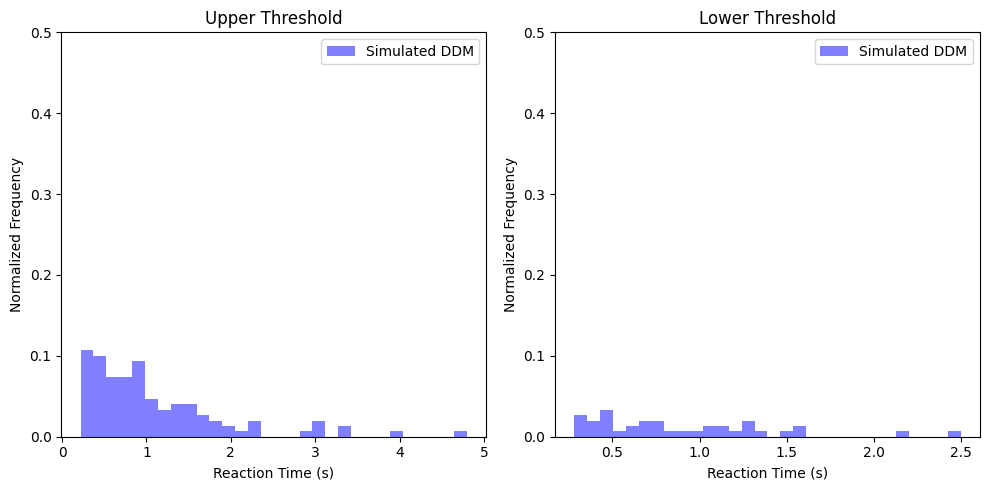

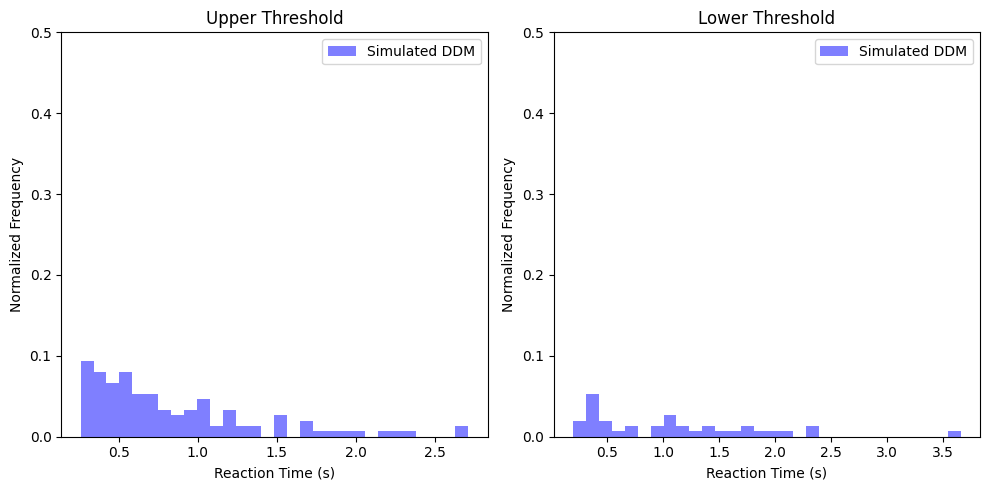

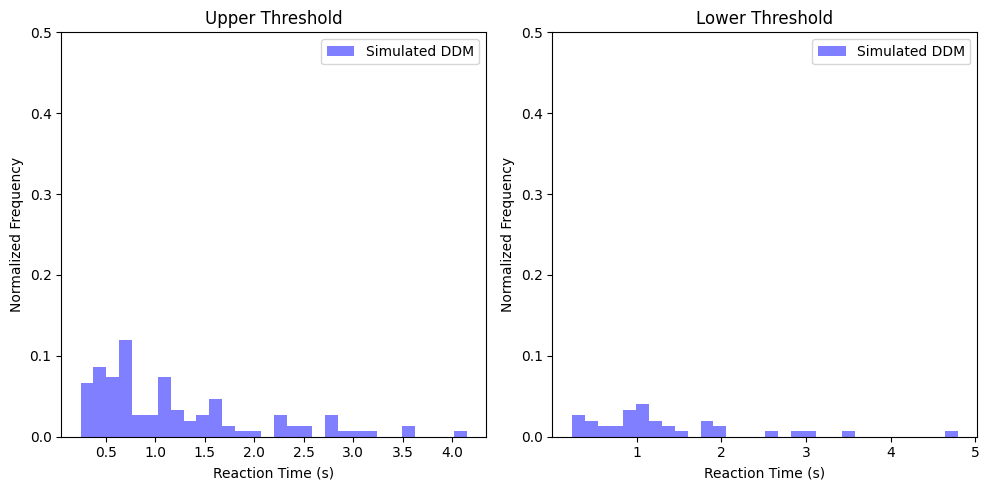

In [8]:
"""
Plots histograms comparing simulated vs empirical reaction time data
for the DDM model, with separate subplots for upper and lower thresholds.

Args:
  rt_upper_simulated: Array of simulated reaction times for upper threshold
  rt_lower_simulated: Array of simulated reaction times for lower threshold
  rt_upper_empirical: Array of empirical reaction times for upper threshold (optional)
  rt_lower_empirical: Array of empirical reaction times for lower threshold (optional)
  y_max: Maximum y-axis limit for histogram (default 0.5)

Returns:
  None. Displays the plot.
"""

def plot_ddm_histograms(rt_upper_simulated, rt_lower_simulated, rt_upper_empirical = None, rt_lower_empirical = None, y_max = 0.5):

  # Calculate the weights for each group to normalize the histograms
  weights_upper_simulated = np.ones_like(rt_upper_simulated) / float(len(rt_upper_simulated)+len(rt_lower_simulated))
  weights_lower_simulated = np.ones_like(rt_lower_simulated) / float(len(rt_upper_simulated)+len(rt_lower_simulated))

  if rt_upper_empirical is not None and rt_lower_empirical is not None:
    weights_upper_empirical = np.ones_like(rt_upper_empirical) / float(len(rt_upper_empirical)+len(rt_lower_empirical))
    weights_lower_empirical = np.ones_like(rt_lower_empirical) / float(len(rt_upper_empirical)+len(rt_lower_empirical))

  # set up figure
  fig, axs = plt.subplots(1, 2, figsize=(10, 5))  # 1 row, 2 columns

  # Plot the histograms for upper threshold
  axs[0].hist(rt_upper_simulated, bins=30, weights=weights_upper_simulated, alpha=0.5, color='blue', label='Simulated DDM')
  if rt_upper_empirical is not None:
    axs[0].hist(rt_upper_empirical, bins=30, weights=weights_upper_empirical, alpha=0.5, color='orange', label='Empirical Data')
  axs[0].set_xlabel('Reaction Time (s)')
  axs[0].set_ylabel('Normalized Frequency')
  axs[0].legend()
  axs[1].set_ylim([0, y_max])
  axs[0].set_title('Upper Threshold')

  # Plot the histograms for lower threshold
  axs[1].hist(rt_lower_simulated, bins=30, weights=weights_lower_simulated, alpha=0.5, color='blue', label='Simulated DDM')
  if rt_upper_empirical is not None:
    axs[1].hist(rt_lower_empirical, bins=30, weights=weights_lower_empirical, alpha=0.5, color='orange', label='Empirical Data')
  axs[1].set_xlabel('Reaction Time (s)')
  axs[1].set_ylabel('Normalized Frequency')
  axs[1].legend()
  axs[0].set_ylim([0, y_max])
  axs[1].set_title('Lower Threshold')

  # Adjust layout
  plt.tight_layout()

  # Display the figure
  plt.show()


# Plotting histogram for the 3 simulated datasets
plot_ddm_histograms(rt_upper_empirical1, rt_lower_empirical1)
plot_ddm_histograms(rt_upper_empirical2, rt_lower_empirical2)
plot_ddm_histograms(rt_upper_empirical3, rt_lower_empirical3)

## Parameter Fitting *(4 points)*




#### The factors are divided into two sets and checked which parameter they influence more

In [9]:
# First set of factors
all_sim_data = pd.concat([exp_sim_dataset1, exp_sim_dataset2, exp_sim_dataset3])
v_exp_1 = hssm.HSSM(
    data=all_sim_data,
    model="ddm",
    loglik_kind="approx_differentiable",
    model_config={
        "bounds": {
            "v": (0.0, 1.0),
            "a": (0.0, 1.0),
            "z": (0.0, 1.0),
            "t": (0.0, 1.0),
        }
    },
    include=[
        {
            "name": "v",
            "formula": "v ~ 1 + task_type + congruency + trial_no_exp_type + task_transition + win_streak_exp_type + loss_streak_exp_type + accuracy_exp_type",
        }
    ],
)

a_exp_1 = hssm.HSSM(
    data=all_sim_data,
    model="ddm",
    loglik_kind="approx_differentiable",
    model_config={
        "bounds": {
            "v": (0.0, 1.0),
            "a": (0.0, 1.0),
            "z": (0.0, 1.0),
            "t": (0.0, 1.0),
        }
    },
    include=[
        {
            "name": "a",
            "formula": "a ~ task_type + congruency + trial_no_exp_type + task_transition + win_streak_exp_type + loss_streak_exp_type + accuracy_exp_type",
        }
    ],
)
z_exp_1 = hssm.HSSM(
    data=all_sim_data,
    model="ddm",
    loglik_kind="approx_differentiable",
    model_config={
        "bounds": {
            "v": (0.0, 1.0),
            "a": (0.0, 1.0),
            "z": (0.0, 1.0),
            "t": (0.0, 1.0),
        }
    },
    include=[
        {
            "name": "z",
            "formula": "z ~ task_type + congruency + trial_no_exp_type + task_transition + win_streak_exp_type + loss_streak_exp_type + accuracy_exp_type",
        }
    ],
)

t_exp_1 = hssm.HSSM(
    data=all_sim_data,
    model="ddm",
    loglik_kind="approx_differentiable",
    model_config={
        "bounds": {
            "v": (0.0, 1.0),
            "a": (0.0, 1.0),
            "z": (0.0, 1.0),
            "t": (0.0, 1.0),
        }
    },
    include=[
        {
            "name": "t",
            "formula": "t ~ task_type + congruency + trial_no_exp_type + task_transition + win_streak_exp_type + loss_streak_exp_type + accuracy_exp_type",
        }
    ],
)

In [75]:
# Fit all the models using MCMC in order to compare and choose the parameter

v_exp_1_model_inference = v_exp_1.sample(
    sampler="nuts_numpyro", # this is the specific MCMC sampling strategy we are using
    cores=1,                # this is the number of CPU cores used to run MCMC sampling
    chains=2,               # this is the number of independent "runs" we sample through the room of parameters
    draws=100,             # this is the number of samples you take to sample each chain (i.e., steps taken to explore the room in one run)
    tune=100,              #  the number of additional steps taken in each chain to adjust and optimize the sampler's settings before the actual sampling starts.
    idata_kwargs=dict(log_likelihood=True),  # we need to include this argument to perform model comparison later on
)

a_exp_1_model_inference = a_exp_1.sample(
    sampler="nuts_numpyro", # this is the specific MCMC sampling strategy we are using
    cores=1,                # this is the number of CPU cores used to run MCMC sampling
    chains=2,               # this is the number of independent "runs" we sample through the room of parameters
    draws=100,             # this is the number of samples you take to sample each chain (i.e., steps taken to explore the room in one run)
    tune=100,              #  the number of additional steps taken in each chain to adjust and optimize the sampler's settings before the actual sampling starts.
    idata_kwargs=dict(log_likelihood=True),  # we need to include this argument to perform model comparison later on
)

z_exp_1_model_inference = z_exp_1.sample(
    sampler="nuts_numpyro", # this is the specific MCMC sampling strategy we are using
    cores=1,                # this is the number of CPU cores used to run MCMC sampling
    chains=2,               # this is the number of independent "runs" we sample through the room of parameters
    draws=100,             # this is the number of samples you take to sample each chain (i.e., steps taken to explore the room in one run)
    tune=100,              #  the number of additional steps taken in each chain to adjust and optimize the sampler's settings before the actual sampling starts.
    idata_kwargs=dict(log_likelihood=True),  # we need to include this argument to perform model comparison later on
)

t_exp_1_model_inference = t_exp_1.sample(
    sampler="nuts_numpyro", # this is the specific MCMC sampling strategy we are using
    cores=1,                # this is the number of CPU cores used to run MCMC sampling
    chains=2,               # this is the number of independent "runs" we sample through the room of parameters
    draws=100,             # this is the number of samples you take to sample each chain (i.e., steps taken to explore the room in one run)
    tune=100,              #  the number of additional steps taken in each chain to adjust and optimize the sampler's settings before the actual sampling starts.
    idata_kwargs=dict(log_likelihood=True),  # we need to include this argument to perform model comparison later on
)


model_comparison = az.compare(
    {
        "v Experiment Type 1": v_exp_1.traces,
        "a Experiment Type 2": a_exp_1.traces,
        "z Experiment Type 3": z_exp_1.traces,
        "t0 Experiment Type 4": t_exp_1.traces,
    }
)

model_comparison

/usr/local/lib/python3.10/dist-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype float64 requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype float64 requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype float64 requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype float64 requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arviz/stats/stats.py:803: UserWarning: Estimated

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
v Experiment Type 1,0,-28467.650835,5103.125531,0.000000,0.252300,273.792073,0.000000,True,log
z Experiment Type 3,1,-28496.374567,11777.315934,28.723732,0.716212,257.001313,383.750639,True,log
t0 Experiment Type 4,2,-29578.646079,3432.294775,1110.995244,0.011725,90.520832,289.384421,True,log
a Experiment Type 2,3,-29592.224795,2563.146976,1124.573960,0.019762,87.766515,288.238712,True,log


Based on the above, we can safely assume the dependence of all the factors on drift rate compared to the other parameters, and thus v is dependent on them

In [11]:
"""
Simulation model for experiment 1

Args:
- data: exp_sim_dataset1 (Dataset)
- model: "ddm" (str)
- loglik_kind: "approx_differentiable" (str)
- model_config: Dictionary with model configuration parameters:
- bounds: Dictionary specifying the bounds for model parameters (v, a, z, t)

"""

exp_1_sim_model = hssm.HSSM(
    data=exp_sim_dataset1,
    model="ddm",
    loglik_kind="approx_differentiable",
    model_config={
        "bounds": {
            "v": (0.0, 1.0),
            "a": (0.0, 1.0),
            "z": (0.0, 1.0),
            "t": (0.0, 1.0),
        }
    },
    include=[
        {
            "name": "v",
            "formula": "v ~ task_transition + win_streak_exp_type + loss_streak_exp_type + accuracy_exp_type + task_type + congruency + trial_no_exp_type",
        }
    ],
)

In [12]:
"""
Simulation model for experiment 2

Args:
- data: exp_sim_dataset2 (Dataset)
- model: "ddm" (str)
- loglik_kind: "approx_differentiable" (str)
- model_config: Dictionary with model configuration parameters:
- bounds: Dictionary specifying the bounds for model parameters (v, a, z, t)

"""

exp_2_sim_model = hssm.HSSM(
    data=exp_sim_dataset2,
    model="ddm",
    loglik_kind="approx_differentiable",
    model_config={
        "bounds": {
            "v": (0.0, 1.0),
            "a": (0.0, 1.0),
            "z": (0.0, 1.0),
            "t": (0.0, 1.0),
        }
    },
    include=[
        {
            "name": "v",
            "formula": "v ~ task_transition + win_streak_exp_type + loss_streak_exp_type + accuracy_exp_type + task_type + congruency + trial_no_exp_type",
        }
    ],
)

In [13]:
"""
Simulation model for experiment 3

Args:
- data: exp_sim_dataset2 (Dataset)
- model: "ddm" (str)
- loglik_kind: "approx_differentiable" (str)
- model_config: Dictionary with model configuration parameters:
- bounds: Dictionary specifying the bounds for model parameters (v, a, z, t)

"""

exp_3_sim_model = hssm.HSSM(
    data=exp_sim_dataset3,
    model="ddm",
    loglik_kind="approx_differentiable",
    model_config={
        "bounds": {
            "v": (0.0, 1.0),
            "a": (0.0, 1.0),
            "z": (0.0, 1.0),
            "t": (0.0, 1.0),
        }
    },
    include=[
        {
            "name": "v",
            "formula": "v ~ task_transition + win_streak_exp_type + loss_streak_exp_type + accuracy_exp_type + task_type + congruency + trial_no_exp_type",
        }
    ],
)

In [14]:


"""
Experiment 1 Model Inference Documentation

Description:
This script performs model inference for Experiment 1 using a specified MCMC sampling strategy (NUTS - No-U-Turn Sampler) implemented in the 'numpyro' library.

Usage:
- Ensure that 'exp_1_sim_model' is an initialized simulation model for Experiment 1.

Parameters:
- sampler: "nuts_numpyro" (str)
  This is the specific MCMC sampling strategy used for inference.
- cores: 1 (int)
  Number of CPU cores used to run MCMC sampling.
- chains: 40 (int)
  Number of independent runs sampled through the parameter space.
- draws: 200 (int)
  Number of samples taken for each chain, representing steps taken to explore the parameter space in one run.
- tune: 500 (int)
  Number of additional steps taken in each chain to adjust and optimize the sampler's settings before actual sampling starts.
- idata_kwargs: Dictionary
  Additional arguments passed to the 'idata_kwargs' parameter for model comparison. In this case, 'log_likelihood' is set to True.

"""

exp_1_model_inference = exp_1_sim_model.sample(
    sampler="nuts_numpyro", # this is the specific MCMC sampling strategy we are using
    cores=1,                # this is the number of CPU cores used to run MCMC sampling
    chains=2,               # this is the number of independent "runs" we sample through the room of parameters
    draws=100,             # this is the number of samples you take to sample each chain (i.e., steps taken to explore the room in one run)
    tune=100,              #  the number of additional steps taken in each chain to adjust and optimize the sampler's settings before the actual sampling starts.
    idata_kwargs=dict(log_likelihood=True),  # we need to include this argument to perform model comparison later on
)

/usr/local/lib/python3.10/dist-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype float64 requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

In [15]:

exp_2_model_inference = exp_2_sim_model.sample(
    sampler="nuts_numpyro", # this is the specific MCMC sampling strategy we are using
    cores=1,                # this is the number of CPU cores used to run MCMC sampling
    chains=2,               # this is the number of independent "runs" we sample through the room of parameters
    draws=100,             # this is the number of samples you take to sample each chain (i.e., steps taken to explore the room in one run)
    tune=100,              #  the number of additional steps taken in each chain to adjust and optimize the sampler's settings before the actual sampling starts.
    idata_kwargs=dict(log_likelihood=True),  # we need to include this argument to perform model comparison later on
)

/usr/local/lib/python3.10/dist-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype float64 requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

In [16]:

exp_3_model_inference = exp_3_sim_model.sample(
    sampler="nuts_numpyro", # this is the specific MCMC sampling strategy we are using
    cores=1,                # this is the number of CPU cores used to run MCMC sampling
    chains=2,               # this is the number of independent "runs" we sample through the room of parameters
    draws=100,             # this is the number of samples you take to sample each chain (i.e., steps taken to explore the room in one run)
    tune=100,              #  the number of additional steps taken in each chain to adjust and optimize the sampler's settings before the actual sampling starts.
    idata_kwargs=dict(log_likelihood=True),  # we need to include this argument to perform model comparison later on
)

/usr/local/lib/python3.10/dist-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype float64 requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

## Parameter Recovery *(5 points)*





Summary and Plot trace for all the simulated models after fitting. This is done to check how the model fits the data, and what parameters are recovered from it.

In [17]:
exp_1_sim_model.summary()

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
v_Intercept,-2.897,0.809,-3.716,-2.080,0.549,0.457,3.0,22.0,1.98
v_task_transition,0.884,0.037,0.847,0.921,0.025,0.021,3.0,30.0,2.10
v_win_streak_exp_type,0.317,0.212,0.105,0.528,0.144,0.120,3.0,17.0,2.55
v_loss_streak_exp_type,-0.171,0.246,-0.416,0.075,0.167,0.139,3.0,14.0,2.34
v_accuracy_exp_type,-0.382,0.154,-0.536,-0.229,0.104,0.087,3.0,28.0,2.02
v_task_type,-0.215,0.346,-0.560,0.131,0.235,0.195,3.0,12.0,2.10
v_congruency,0.277,0.839,-0.560,1.114,0.569,0.474,2.0,15.0,2.80
v_trial_no_exp_type,0.017,0.002,0.015,0.019,0.001,0.001,3.0,45.0,1.94
a,0.564,0.116,0.448,0.679,0.078,0.065,3.0,23.0,2.33
z,0.533,0.086,0.447,0.619,0.059,0.049,3.0,43.0,1.87


In [18]:
exp_2_sim_model.summary()

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
v_Intercept,-1.005,2.362,-3.403,1.352,1.602,1.334,3.0,19.0,2.37
v_task_transition,-0.153,0.880,-1.032,0.724,0.597,0.497,2.0,35.0,3.29
v_win_streak_exp_type,0.154,0.222,-0.067,0.376,0.150,0.125,2.0,12.0,2.94
v_loss_streak_exp_type,-0.650,0.612,-1.261,-0.039,0.415,0.346,3.0,2.0,2.47
v_accuracy_exp_type,0.063,0.031,0.031,0.094,0.021,0.017,3.0,25.0,2.44
v_task_type,-0.079,0.229,-0.307,0.150,0.155,0.129,2.0,2.0,3.70
v_congruency,-1.060,0.035,-1.095,-1.025,0.024,0.020,3.0,2.0,2.71
v_trial_no_exp_type,0.016,0.012,0.005,0.029,0.008,0.007,3.0,22.0,2.20
a,0.687,0.036,0.651,0.723,0.024,0.020,3.0,41.0,2.23
z,0.567,0.036,0.530,0.603,0.025,0.020,3.0,19.0,2.38


In [19]:
exp_3_sim_model.summary()

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
v_Intercept,0.123,1.405,-1.296,1.530,0.953,0.793,3.0,85.0,1.88
v_task_transition,-0.428,0.419,-0.847,-0.010,0.284,0.237,3.0,12.0,2.22
v_win_streak_exp_type,-0.015,0.483,-0.497,0.467,0.327,0.272,3.0,14.0,2.47
v_loss_streak_exp_type,0.115,0.640,-0.523,0.754,0.434,0.361,3.0,13.0,2.20
v_accuracy_exp_type,-0.001,0.165,-0.166,0.164,0.112,0.093,3.0,12.0,2.20
v_task_type,-0.090,0.858,-0.947,0.766,0.582,0.485,3.0,15.0,2.20
v_congruency,0.103,0.282,-0.178,0.385,0.191,0.159,3.0,12.0,1.99
v_trial_no_exp_type,0.001,0.001,-0.000,0.001,0.001,0.000,3.0,40.0,1.86
a,0.514,0.094,0.420,0.608,0.064,0.053,3.0,14.0,2.43
z,0.599,0.001,0.598,0.599,0.000,0.000,3.0,22.0,2.30


/usr/local/lib/python3.10/dist-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


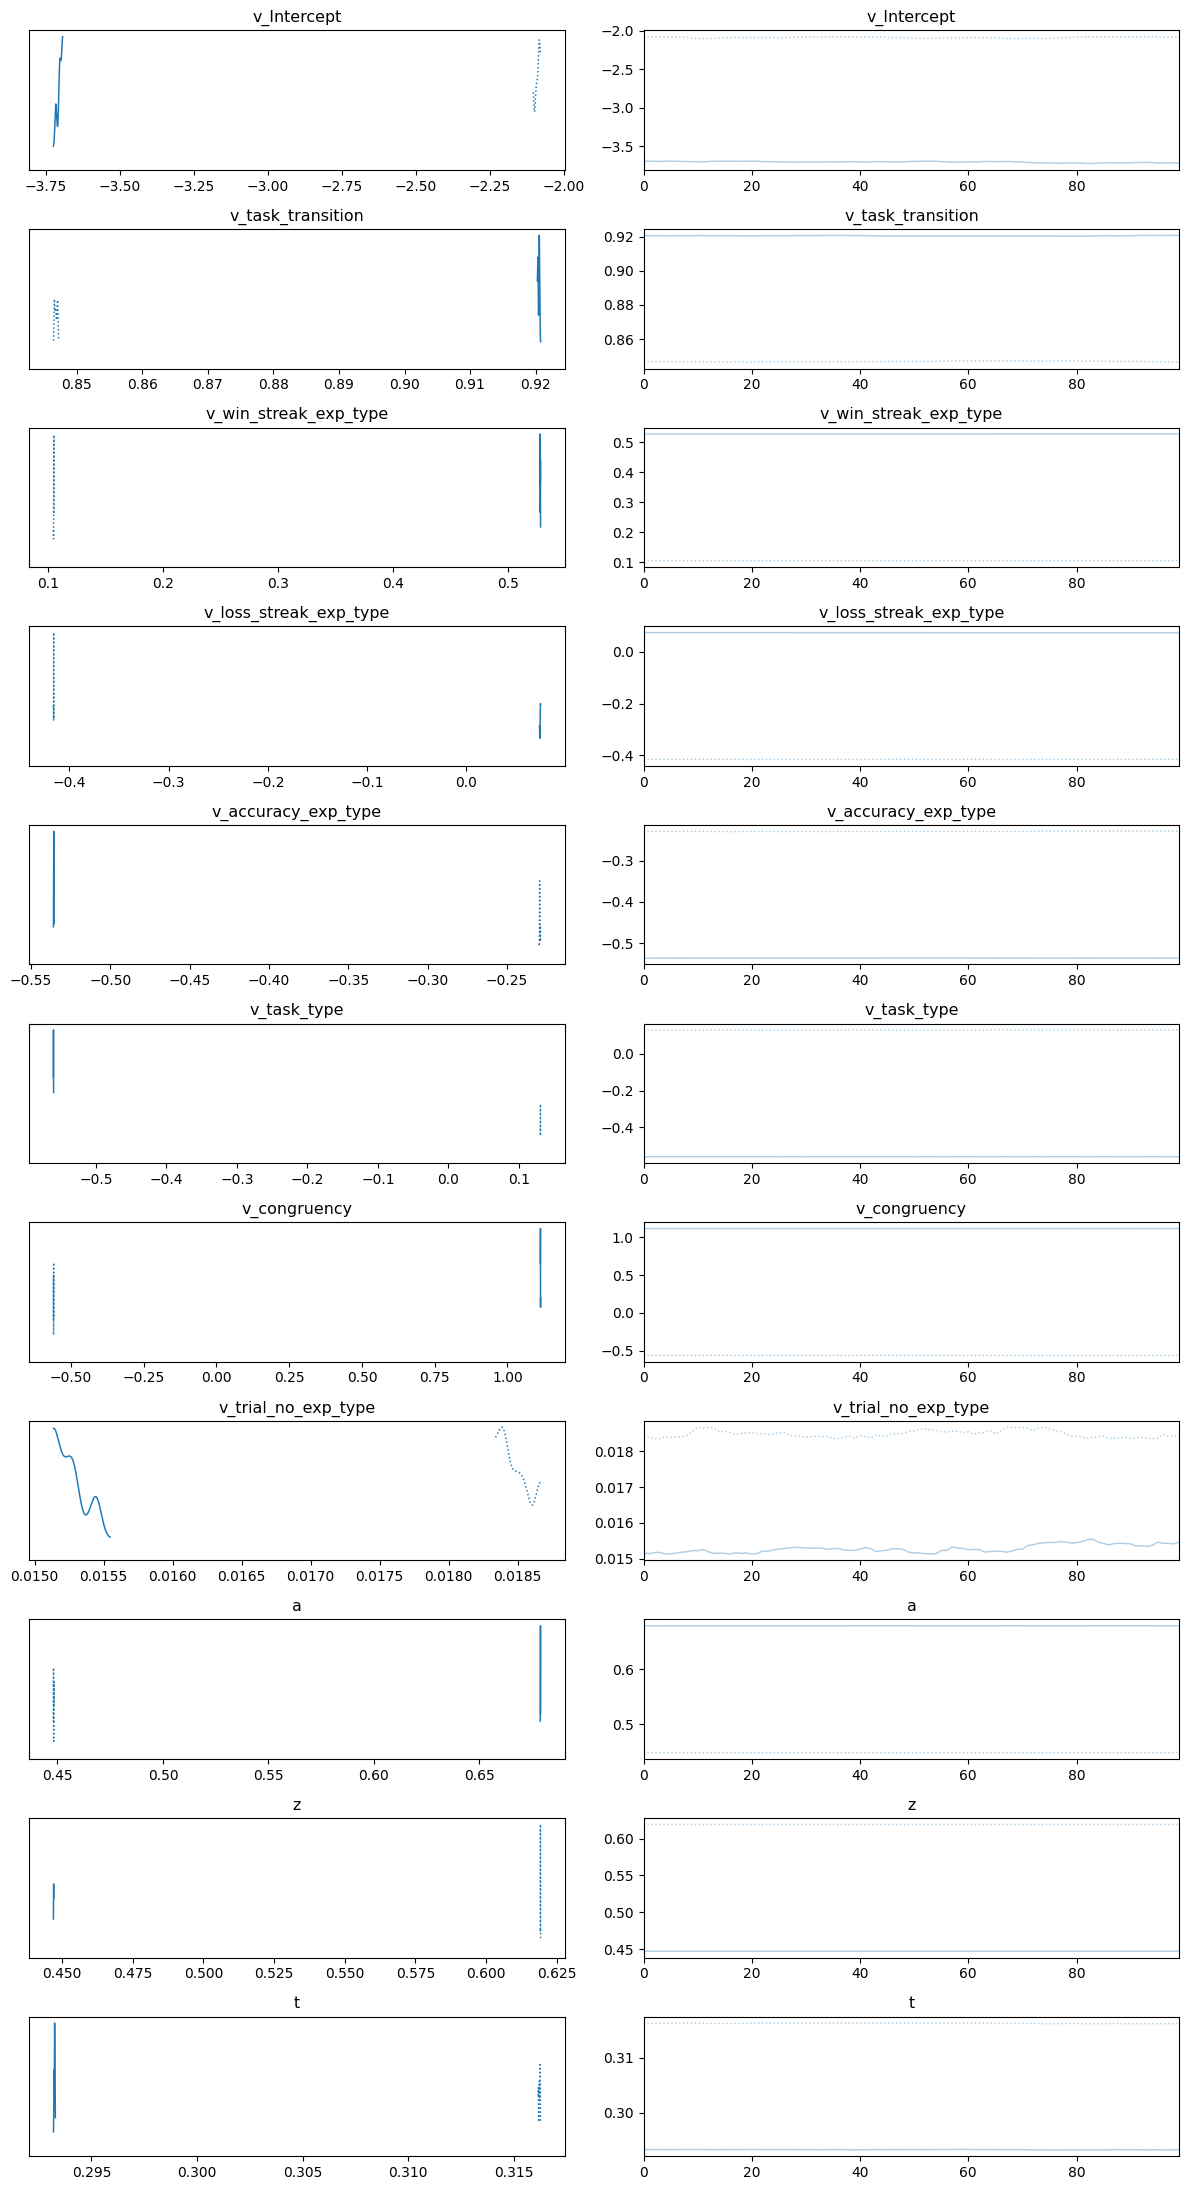

In [20]:
exp_1_sim_model.plot_trace()

/usr/local/lib/python3.10/dist-packages/arviz/stats/density_utils.py:487: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/usr/local/lib/python3.10/dist-packages/arviz/stats/density_utils.py:487: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/usr/local/lib/python3.10/dist-packages/arviz/stats/density_utils.py:487: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/usr/local/lib/python3.10/dist-packages/arviz/stats/density_utils.py:487: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/usr/local/lib/python3.10/dist-packages/arviz/stats/density_utils.py:487: UserWarning: Y

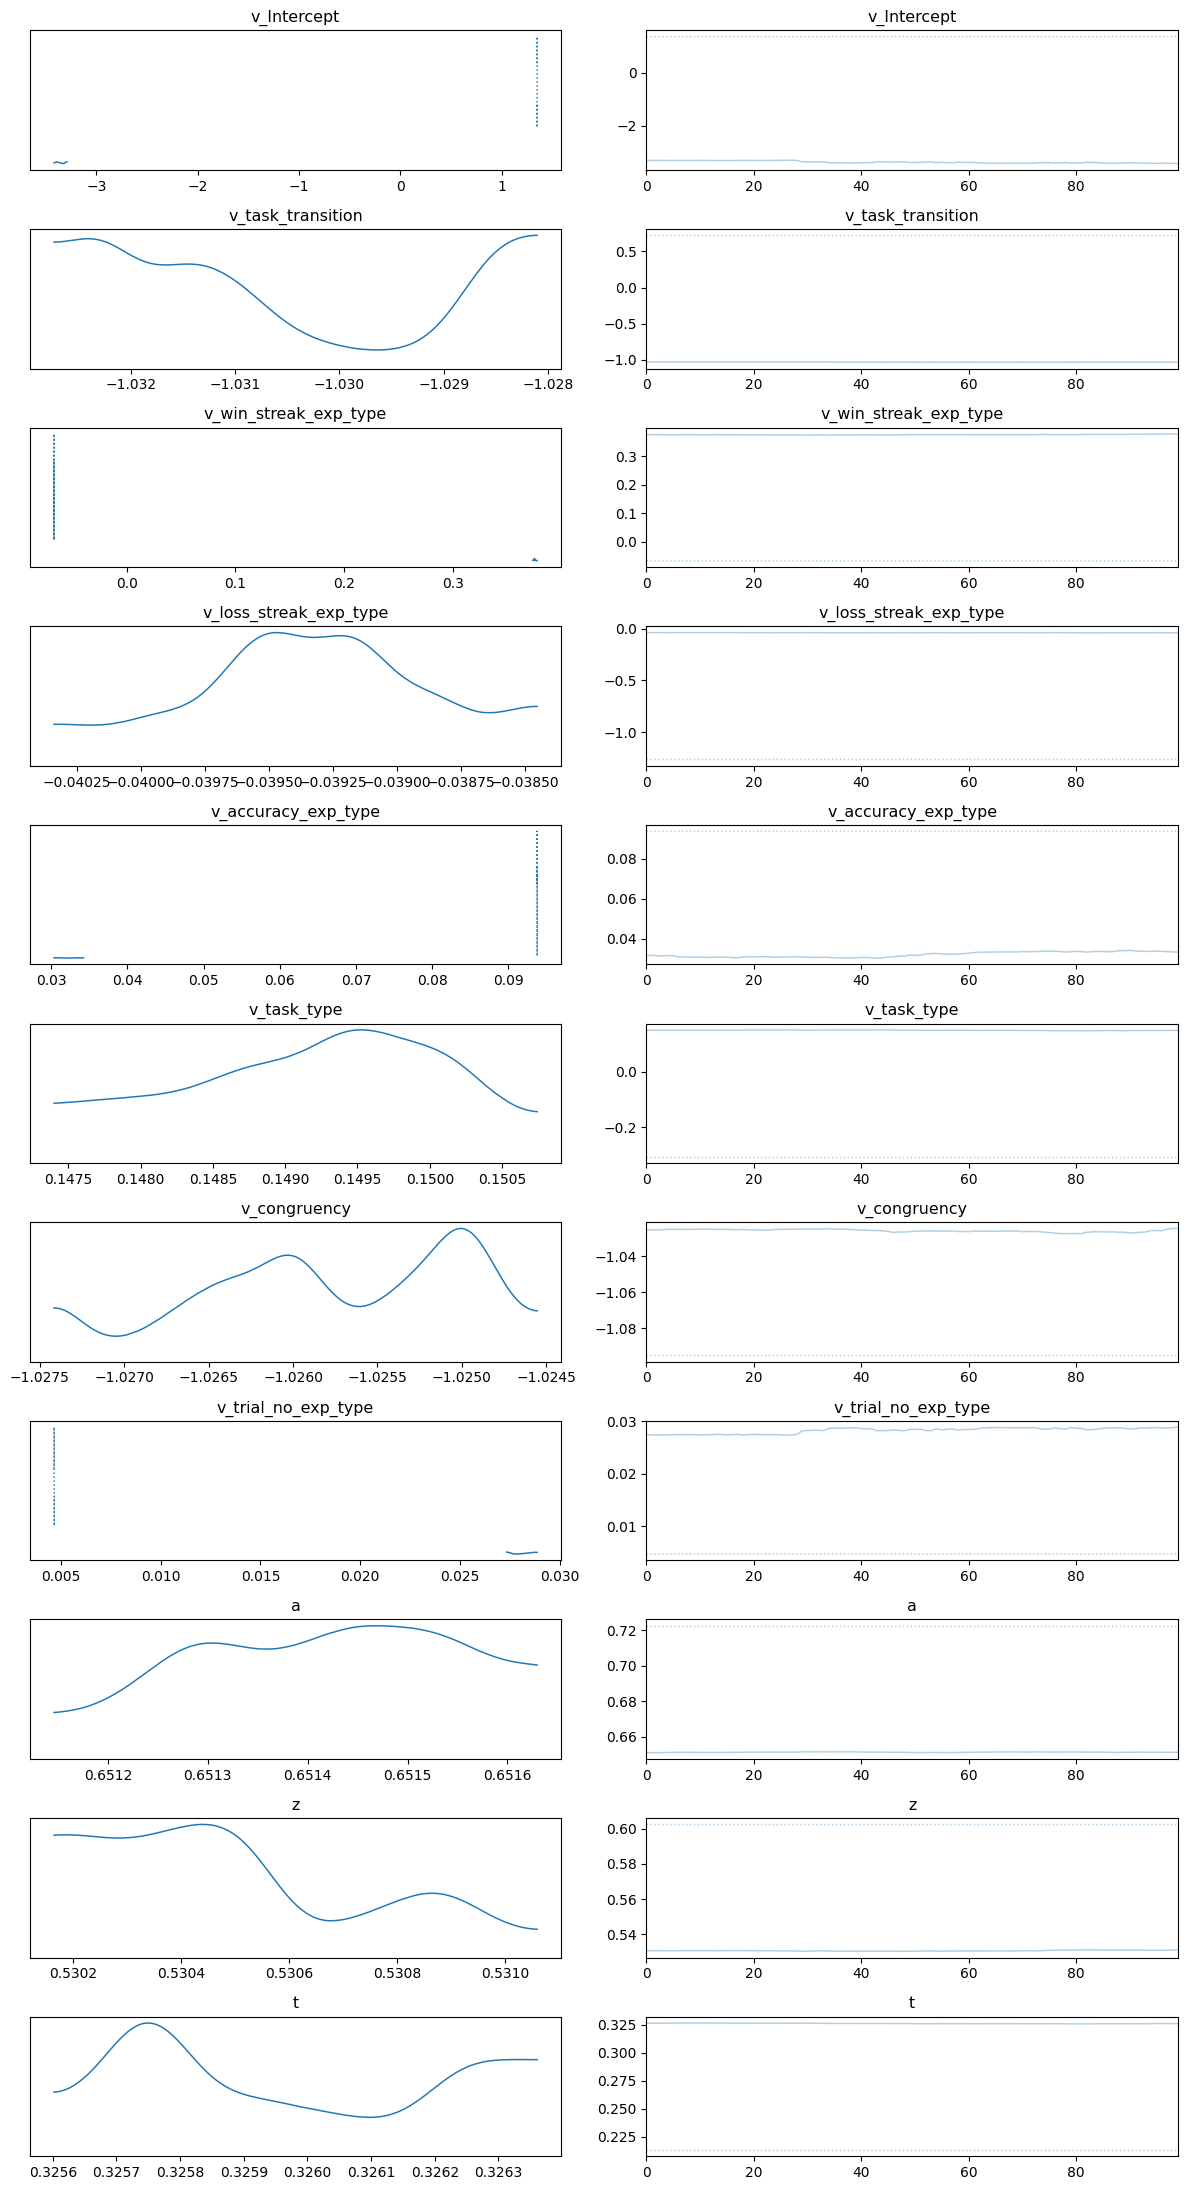

In [21]:
exp_2_sim_model.plot_trace()

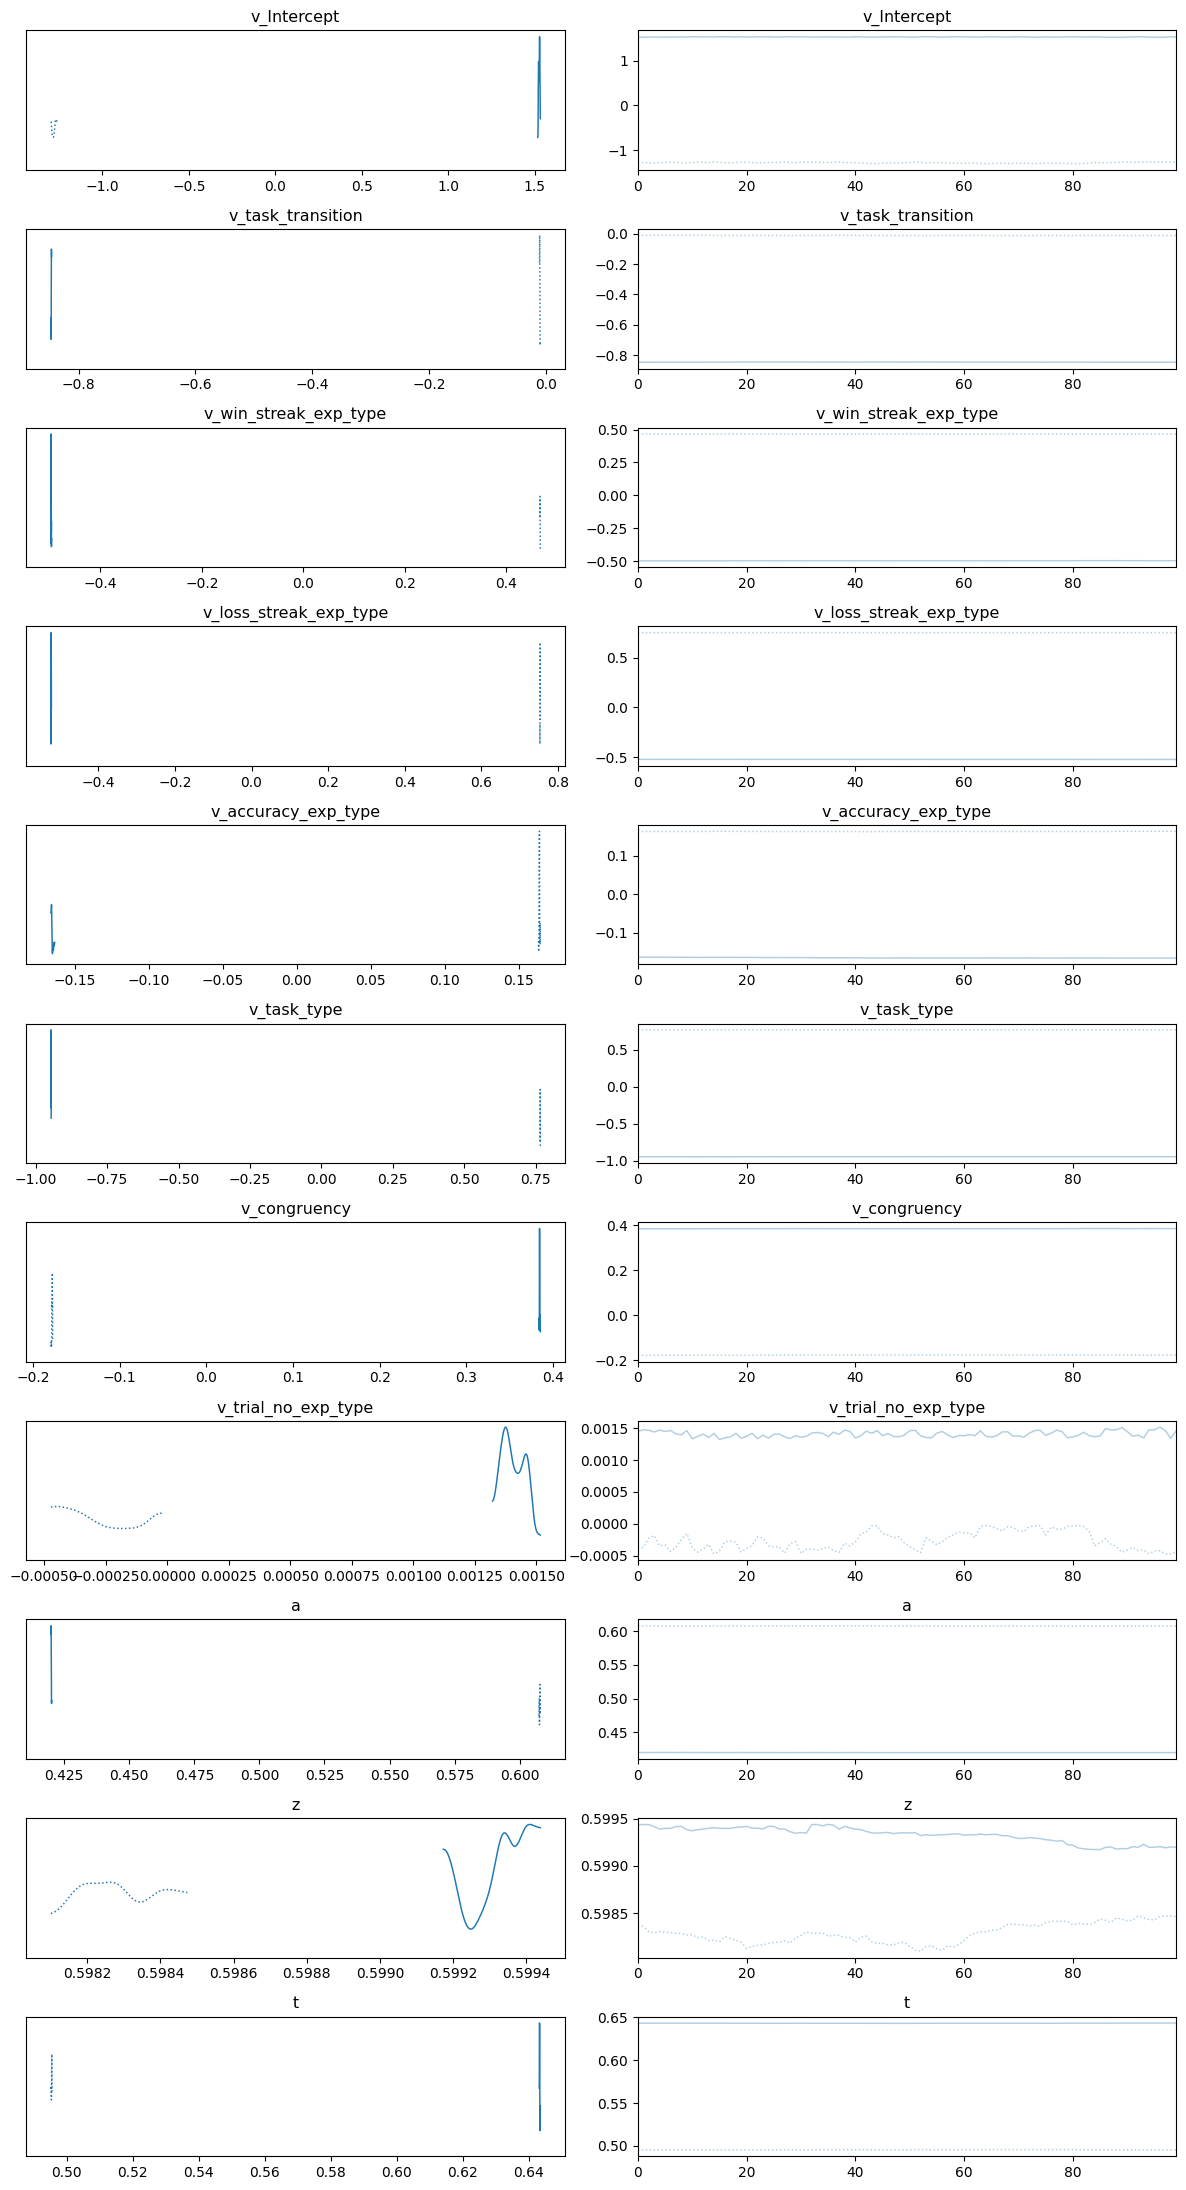

In [22]:
exp_3_sim_model.plot_trace()

Plotting posterior dist


No posterior predictive samples found. Generating posterior predictive samples using the provided InferenceData object and the original data. This will modify the provided InferenceData object, or if not provided, the traces object stored inside the model.


INFO:hssm:No posterior predictive samples found. Generating posterior predictive samples using the provided InferenceData object and the original data. This will modify the provided InferenceData object, or if not provided, the traces object stored inside the model.


<Axes: title={'center': 'Posterior Predictive Distribution'}, xlabel='Response Time', ylabel='Density'>

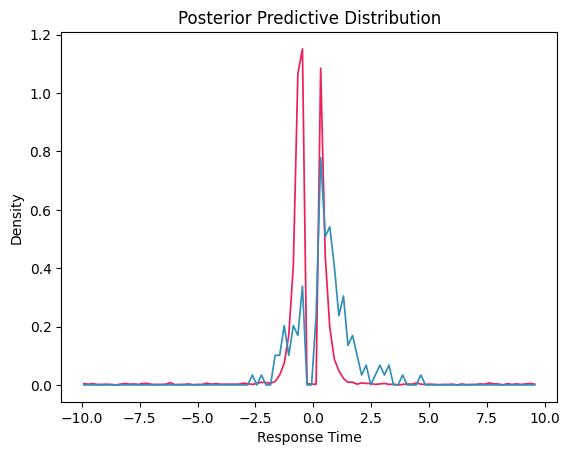

In [23]:
hssm.plotting.plot_posterior_predictive(exp_1_sim_model)

No posterior predictive samples found. Generating posterior predictive samples using the provided InferenceData object and the original data. This will modify the provided InferenceData object, or if not provided, the traces object stored inside the model.


INFO:hssm:No posterior predictive samples found. Generating posterior predictive samples using the provided InferenceData object and the original data. This will modify the provided InferenceData object, or if not provided, the traces object stored inside the model.


<Axes: title={'center': 'Posterior Predictive Distribution'}, xlabel='Response Time', ylabel='Density'>

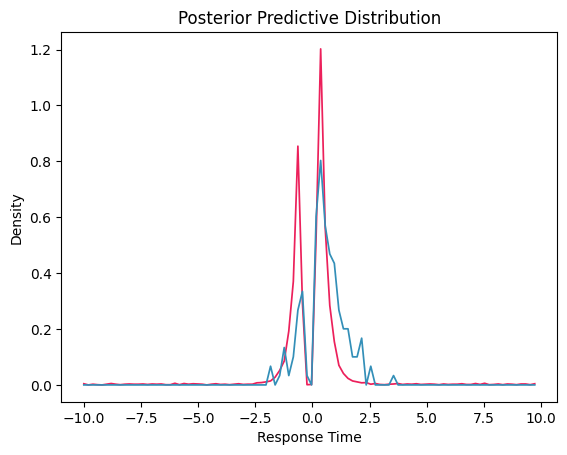

In [24]:
hssm.plotting.plot_posterior_predictive(exp_2_sim_model)

No posterior predictive samples found. Generating posterior predictive samples using the provided InferenceData object and the original data. This will modify the provided InferenceData object, or if not provided, the traces object stored inside the model.


INFO:hssm:No posterior predictive samples found. Generating posterior predictive samples using the provided InferenceData object and the original data. This will modify the provided InferenceData object, or if not provided, the traces object stored inside the model.


<Axes: title={'center': 'Posterior Predictive Distribution'}, xlabel='Response Time', ylabel='Density'>

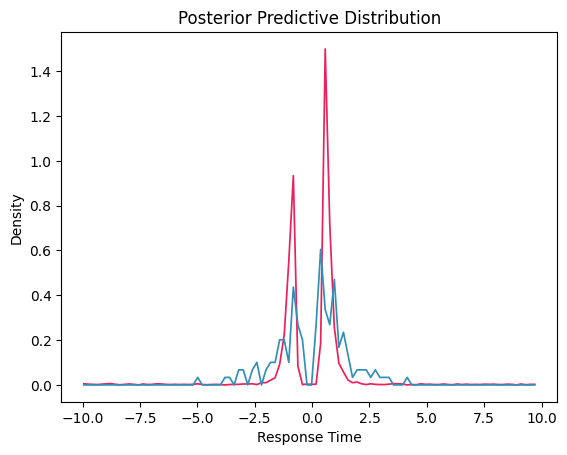

In [25]:
hssm.plotting.plot_posterior_predictive(exp_3_sim_model)

Approximately finding the v value by taking the slope values and intercepts and implementing a simple line equation and averaging the values and getting the Percentage Error

In [70]:
def predict_linear_regression(df, slopes, intercept, x_columns):
    """
    Predicts the values of y using the given slope and intercept for a linear regression model.

    Parameters:
        df (DataFrame): The DataFrame containing the data.
        slope (float): The slope (m) of the linear regression model.
        intercept (float): The intercept (c) of the linear regression model.
        x_column (str): The name of the column containing the predictor variable (x).

    Returns:
        Series: A Series containing the predicted values (y).
    """
    # Compute predicted values (y) using the linear regression equation y = mx + c
    for i in range(len(x_columns)):
      if i == 0:
        predicted_values = slopes[i] * df[x_columns[i]]
      else:
        predicted_values += slopes[i] * df[x_columns[i]]
    predicted_values += intercept
    return predicted_values

def rmse(predicted_value, actual_value):
  mse = (predicted_value - actual_value)**2
  rmse = np.mean(mse)**0.5
  return rmse

# For the 1st simulated dataset
column_list = list(exp_sim_dataset1.columns)
summary = exp_1_sim_model.summary()
model_param = list(summary.index)
intercept_val = 0
x_columns = []
slopes = []
for i in model_param:
  for j in column_list:
    if j in i:
      x_columns.append(j)
      slopes.append(summary[summary.index == i].iloc[0,0])
    elif 'intercept' in i:
      intercept_val = summary[summary.index == i].iloc[0,0]

predicted_value = predict_linear_regression(exp_sim_dataset1, slopes, intercept_val, x_columns)
rmse_val = rmse(predicted_value, v_1)
print('The root mean square error for the simulated data of the 1st Experiment is {}'.format(rmse_val.round(2)))

The root mean square error for the simulated data of the 1st Experiment is 2.05


In [71]:
# For the 2nd simulated dataset
column_list = list(exp_sim_dataset2.columns)
summary = exp_2_sim_model.summary()
model_param = list(summary.index)
x_columns = []
slopes = []
for i in model_param:
  for j in column_list:
    if j in i:
      x_columns.append(j)
      slopes.append(summary[summary.index == i].iloc[0,0])
    elif 'intercept' in i:
      intercept_val = summary[summary.index == i].iloc[0,0]

predicted_value = predict_linear_regression(exp_sim_dataset2, slopes, intercept_val, x_columns)
rmse_val = rmse(predicted_value, v_2)
print('The root mean square error for the simulated data of the 2nd Experiment is {}'.format(rmse_val.round(2)))

The root mean square error for the simulated data of the 2nd Experiment is 1.4


In [72]:
# For the 3rd simulated dataset
column_list = list(exp_sim_dataset3.columns)
summary = exp_3_sim_model.summary()
model_param = list(summary.index)
x_columns = []
slopes = []
for i in model_param:
  for j in column_list:
    if j in i:
      x_columns.append(j)
      slopes.append(summary[summary.index == i].iloc[0,0])
    elif 'intercept' in i:
      intercept_val = summary[summary.index == i].iloc[0,0]

predicted_value = predict_linear_regression(exp_sim_dataset3, slopes, intercept_val, x_columns)
rmse_val = rmse(predicted_value, v_3)
print('The root mean square error for the simulated data of the 3rd Experiment is {}'.format(rmse_val.round(2)))

The root mean square error for the simulated data of the 3rd Experiment is 0.43


## *Optional*: Model Recovery *(2 bonus points)*

In this bonus exercise, you may examine model reovery. The bonus points count towards your total group project points. That is, you may accumlate up to 22 points in the practical part of the group project.

Make sure to comment your code and provide an explanation for each code block in a preceding text block.





In [29]:
# YOUR MODEL RECOVERY CODE GOES HERE

## Model Comparison *(5 points)*



Experimental Data Preprocessing

In [35]:
exp_data_req_1 = pd.read_csv('experiment_data.csv')
exp_data_req_2 = pd.read_csv('experiment_data_2.csv')
exp_data_req_3 = pd.read_csv('experiment_data_3.csv')

exp_data_req = pd.concat([exp_data_req_1,exp_data_req_2,exp_data_req_3],ignore_index=True)
exp_data_req = exp_data_req[exp_data_req['experiment_type']!=-1]

exp_data_req.drop(['coherent_movement_direction', 'coherent_orientation', 'key_press'], axis = 1, inplace = True)
exp_data_req.rename({'correct':'response'},axis=1, inplace = True)
exp_data_req['response'] = exp_data_req['response'].replace([True,False],[1,-1])
exp_data_req['rt'] = exp_data_req['rt']/1000

In [36]:
label_encoding_column_list = []

for column in exp_data_req.columns:
    if not pd.api.types.is_numeric_dtype(exp_data_req[column]) or pd.api.types.is_bool_dtype(exp_data_req[column]):
        label_encoding_column_list.append(column)

for i in label_encoding_column_list:
  label_encoder = LabelEncoder()
  exp_data_req[i]= label_encoder.fit_transform(exp_data_req[i])

In [37]:
exp_data_req['trial_no_exp_type'] = 1
exp_data_req['trial_no_exp_type'] = exp_data_req.groupby(['experiment_type'])['trial_no_exp_type'].cumsum()

In [38]:
# Define a custom function to calculate cumulative sum until a zero appears
# Below function is used to check for a change in experiment type in the generated dataset

def cumulative_sum_until_zero(series):
    cum_sum = 0
    cum_sum_list = []
    for value in series:
        if value == 0:
            cum_sum = 0
        else:
            cum_sum += value
        cum_sum_list.append(cum_sum)
    return cum_sum_list

exp_data_req['win_loss'] = exp_data_req['response'].apply(lambda x: 1 if x == 1 else 0)
exp_data_req['loss_win'] = exp_data_req['response'].apply(lambda x: 0 if x == 1 else 1)

exp_data_req['win_streak_exp_type'] = exp_data_req.groupby(['experiment_type'])['win_loss'].transform(cumulative_sum_until_zero)
exp_data_req['loss_streak_exp_type'] = exp_data_req.groupby(['experiment_type'])['loss_win'].transform(cumulative_sum_until_zero)
exp_data_req['accuracy_exp_type'] = exp_data_req.groupby(['experiment_type'])['win_loss'].cumsum()
exp_data_req['accuracy_exp_type'] = exp_data_req['accuracy_exp_type']/exp_data_req['trial_no_exp_type']
exp_data_req['accuracy_exp_type'] = exp_data_req['accuracy_exp_type'].round(2)

In [39]:
for col in exp_data_req.columns:
    if exp_data_req[col].dtype == 'int':
        exp_data_req[col] = exp_data_req[col].astype('float64')

In [40]:
exp_type_1 = exp_data_req[exp_data_req['experiment_type']==0]
exp_type_2 = exp_data_req[exp_data_req['experiment_type']==1]
exp_type_3 = exp_data_req[exp_data_req['experiment_type']==2]

exp_type_1.drop(['experiment_type'], axis = 1, inplace = True)
exp_type_2.drop(['experiment_type'], axis = 1, inplace = True)
exp_type_3.drop(['experiment_type'], axis = 1, inplace = True)

<ipython-input-40-76901e3e1066>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exp_type_1.drop(['experiment_type'], axis = 1, inplace = True)
<ipython-input-40-76901e3e1066>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exp_type_2.drop(['experiment_type'], axis = 1, inplace = True)
<ipython-input-40-76901e3e1066>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exp_type_3.drop(['experiment_type'], axis = 1, inplace = True)


In [41]:
# Filtering out the required dataset

req_exp_type_1 = exp_type_1[['rt', 'response', 'task_type', 'task_transition', 'congruency',
       'trial_no_exp_type', 'win_streak_exp_type', 'loss_streak_exp_type',
       'accuracy_exp_type']]
req_exp_type_2 = exp_type_2[['rt', 'response', 'task_type', 'task_transition', 'congruency',
       'trial_no_exp_type', 'win_streak_exp_type', 'loss_streak_exp_type',
       'accuracy_exp_type']]
req_exp_type_3 = exp_type_3[['rt', 'response', 'task_type', 'task_transition', 'congruency',
       'trial_no_exp_type', 'win_streak_exp_type', 'loss_streak_exp_type',
       'accuracy_exp_type']]

#### Doing the actual hypothesis checks for the 3 experiments

First Experiment

In [42]:
"""
Experiment 1 Hypotheses Documentation

Null Hypothesis Model:
- Initializes a Hidden Semi-Markov Model (HSSM) for Experiment 1.
- Assumes a drift diffusion model (DDM).
- Includes a prior for parameter 'v' with a normal distribution (mean=0.5, sigma=0.3).
- Formula specifies predictors for 'v' in the model.

Alternative Hypothesis Model:
- Initializes another HSSM for Experiment 1.
- Assumes a drift diffusion model (DDM).
- Includes a prior for parameter 'v' with a normal distribution (mean=0.1, sigma=0.1).
- Formula specifies predictors for 'v' in the model.

Note: Ensure that 'hssm' module is imported, and 'exp_type_1' is a valid dataset for Experiment 1.
"""


null_hypothesis_exp_1 = hssm.HSSM(
    data=exp_type_1,
    model="ddm",
    loglik_kind="approx_differentiable",
    model_config={
        "bounds": {
            "v": (0.0, 1.0),
            "a": (0.0, 1.0),
            "z": (0.0, 1.0),
            "t": (0.0, 1.0),
        }
    },
    include=[
        {
            "name": "v",
            "prior": {"name": "Normal", "mu": 0.5, "sigma": 0.3},
            "formula": "v ~ task_transition + win_streak_exp_type + loss_streak_exp_type + accuracy_exp_type + task_type + congruency + trial_no_exp_type",
        }
    ],
)

alt_hypothesis_exp_1 = hssm.HSSM(
    data=exp_type_1,
    model="ddm",
    loglik_kind="approx_differentiable",
    model_config={
        "bounds": {
            "v": (0.0, 1.0),
            "a": (0.0, 1.0),
            "z": (0.0, 1.0),
            "t": (0.0, 1.0),
        }
    },
    include=[
        {
            "name": "v",
            "prior": {"name": "Normal", "mu": 0.1, "sigma": 0.1},
            "formula": "v ~ task_transition + win_streak_exp_type + loss_streak_exp_type + accuracy_exp_type + task_type + congruency + trial_no_exp_type",
        }
    ],
)

In [54]:
# Fit both models using MCMC

null_hypothesis_exp_1_model_inference = null_hypothesis_exp_1.sample(
    sampler="nuts_numpyro", # this is the specific MCMC sampling strategy we are using
    cores=1,                # this is the number of CPU cores used to run MCMC sampling
    chains=2,               # this is the number of independent "runs" we sample through the room of parameters
    draws=100,             # this is the number of samples you take to sample each chain (i.e., steps taken to explore the room in one run)
    tune=100,              #  the number of additional steps taken in each chain to adjust and optimize the sampler's settings before the actual sampling starts.
    idata_kwargs=dict(log_likelihood=True),  # we need to include this argument to perform model comparison later on
)

alt_hypothesis_exp_1_model_inference = alt_hypothesis_exp_1.sample(
    sampler="nuts_numpyro", # this is the specific MCMC sampling strategy we are using
    cores=1,                # this is the number of CPU cores used to run MCMC sampling
    chains=2,               # this is the number of independent "runs" we sample through the room of parameters
    draws=100,             # this is the number of samples you take to sample each chain (i.e., steps taken to explore the room in one run)
    tune=100,              #  the number of additional steps taken in each chain to adjust and optimize the sampler's settings before the actual sampling starts.
    idata_kwargs=dict(log_likelihood=True),  # we need to include this argument to perform model comparison later on
)

model_comparison1 = az.compare(
    {
        "Experiment Type 1": null_hypothesis_exp_1.traces,
        "Experiment Type 2": alt_hypothesis_exp_1.traces,
    }
)

/usr/local/lib/python3.10/dist-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype float64 requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype float64 requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


In [55]:
model_comparison1

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
Experiment Type 1,0,-4173.980538,2833.861709,0.000000,0.683505,297.483864,0.000000,True,log
Experiment Type 2,1,-5151.683242,2860.300395,977.702704,0.316495,245.565399,410.074558,True,log


<Axes: title={'center': 'Model comparison\nhigher is better'}, xlabel='elpd_loo (log)', ylabel='ranked models'>

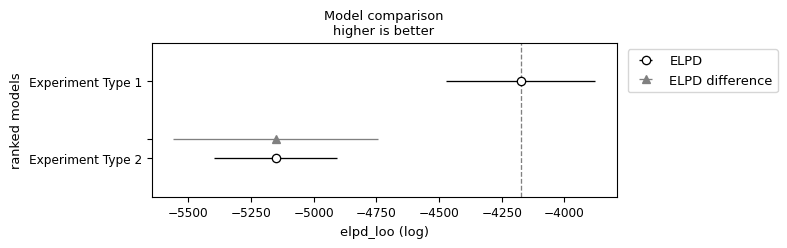

In [56]:
az.plot_compare(model_comparison1)

Second Experiment

In [46]:
"""
Experiment 2 Hypotheses Documentation

Null Hypothesis Model:
- Initializes a Hidden Semi-Markov Model (HSSM) for Experiment 1.
- Assumes a drift diffusion model (DDM).
- Includes a prior for parameter 'v' with a normal distribution (mean=0.7, sigma=0.2).
- Formula specifies predictors for 'v' in the model.

Alternative Hypothesis Model:
- Initializes another HSSM for Experiment 1.
- Assumes a drift diffusion model (DDM).
- Includes a prior for parameter 'v' with a normal distribution (mean=0.1, sigma=0.1).
- Formula specifies predictors for 'v' in the model.

Note: Ensure that 'hssm' module is imported, and 'exp_type_1' is a valid dataset for Experiment 1.
"""


null_hypothesis_exp_2 = hssm.HSSM(
    data=exp_type_2,
    model="ddm",
    loglik_kind="approx_differentiable",
    model_config={
        "bounds": {
            "v": (0.0, 1.0),
            "a": (0.0, 1.0),
            "z": (0.0, 1.0),
            "t": (0.0, 1.0),
        }
    },
    include=[
        {
            "name": "v",
            "prior": {"name": "Normal", "mu": 0.7, "sigma": 0.2},
            "formula": "v ~ task_transition + win_streak_exp_type + loss_streak_exp_type + accuracy_exp_type + task_type + congruency + trial_no_exp_type",
        }
    ],
)

alt_hypothesis_exp_2 = hssm.HSSM(
    data=exp_type_2,
    model="ddm",
    loglik_kind="approx_differentiable",
    model_config={
        "bounds": {
            "v": (0.0, 1.0),
            "a": (0.0, 1.0),
            "z": (0.0, 1.0),
            "t": (0.0, 1.0),
        }
    },
    include=[
        {
            "name": "v",
            "prior": {"name": "Normal", "mu": 0.1, "sigma": 0.1},
            "formula": "v ~ task_transition + win_streak_exp_type + loss_streak_exp_type + accuracy_exp_type + task_type + congruency + trial_no_exp_type",
        }
    ],
)

In [59]:
# Fit both models using MCMC

null_hypothesis_exp_2_model_inference = null_hypothesis_exp_2.sample(
    sampler="nuts_numpyro", # this is the specific MCMC sampling strategy we are using
    cores=1,                # this is the number of CPU cores used to run MCMC sampling
    chains=2,               # this is the number of independent "runs" we sample through the room of parameters
    draws=100,             # this is the number of samples you take to sample each chain (i.e., steps taken to explore the room in one run)
    tune=100,              #  the number of additional steps taken in each chain to adjust and optimize the sampler's settings before the actual sampling starts.
    idata_kwargs=dict(log_likelihood=True),  # we need to include this argument to perform model comparison later on
)

alt_hypothesis_exp_2_model_inference = alt_hypothesis_exp_2.sample(
    sampler="nuts_numpyro", # this is the specific MCMC sampling strategy we are using
    cores=1,                # this is the number of CPU cores used to run MCMC sampling
    chains=2,               # this is the number of independent "runs" we sample through the room of parameters
    draws=100,             # this is the number of samples you take to sample each chain (i.e., steps taken to explore the room in one run)
    tune=100,              #  the number of additional steps taken in each chain to adjust and optimize the sampler's settings before the actual sampling starts.
    idata_kwargs=dict(log_likelihood=True),  # we need to include this argument to perform model comparison later on
)

model_comparison2 = az.compare(
    {
        "Experiment Type 1": null_hypothesis_exp_2.traces,
        "Experiment Type 2": alt_hypothesis_exp_2.traces,
    }
)

/usr/local/lib/python3.10/dist-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype float64 requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype float64 requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


In [60]:
model_comparison2

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
Experiment Type 1,0,-4345.195160,2912.031269,0.000000,0.67928,288.817089,0.000000,True,log
Experiment Type 2,1,-5267.231108,3325.566425,922.035948,0.32072,236.280634,373.785619,True,log


<Axes: title={'center': 'Model comparison\nhigher is better'}, xlabel='elpd_loo (log)', ylabel='ranked models'>

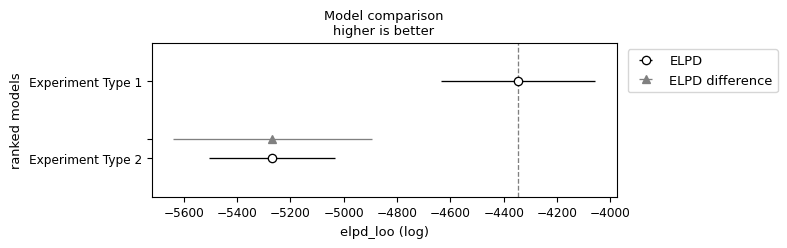

In [61]:
az.plot_compare(model_comparison2)

Third Experiment

In [62]:
"""
Experiment 3 Hypotheses Documentation

Null Hypothesis Model:
- Initializes a Hidden Semi-Markov Model (HSSM) for Experiment 1.
- Assumes a drift diffusion model (DDM).
- Includes a prior for parameter 'v' with a normal distribution (mean=0.3, sigma=0.2).
- Formula specifies predictors for 'v' in the model.

Alternative Hypothesis Model:
- Initializes another HSSM for Experiment 1.
- Assumes a drift diffusion model (DDM).
- Includes a prior for parameter 'v' with a normal distribution (mean=0.7, sigma=0.2).
- Formula specifies predictors for 'v' in the model.

Note: Ensure that 'hssm' module is imported, and 'exp_type_1' is a valid dataset for Experiment 1.
"""


null_hypothesis_exp_3 = hssm.HSSM(
    data=exp_type_3,
    model="ddm",
    loglik_kind="approx_differentiable",
    model_config={
        "bounds": {
            "v": (0.0, 1.0),
            "a": (0.0, 1.0),
            "z": (0.0, 1.0),
            "t": (0.0, 1.0),
        }
    },
    include=[
        {
            "name": "v",
            "prior": {"name": "Normal", "mu": 0.3, "sigma": 0.2},
            "formula": "v ~ task_transition + win_streak_exp_type + loss_streak_exp_type + accuracy_exp_type + task_type + congruency + trial_no_exp_type",
        }
    ],
)

alt_hypothesis_exp_3 = hssm.HSSM(
    data=exp_type_3,
    model="ddm",
    loglik_kind="approx_differentiable",
    model_config={
        "bounds": {
            "v": (0.0, 1.0),
            "a": (0.0, 1.0),
            "z": (0.0, 1.0),
            "t": (0.0, 1.0),
        }
    },
    include=[
        {
            "name": "v",
            "prior": {"name": "Normal", "mu": 0.7, "sigma": 0.2},
            "formula": "v ~ task_transition + win_streak_exp_type + loss_streak_exp_type + accuracy_exp_type + task_type + congruency + trial_no_exp_type",
        }
    ],
)

In [66]:
# Fit both models using MCMC

null_hypothesis_exp_3_model_inference = null_hypothesis_exp_3.sample(
    sampler="nuts_numpyro", # this is the specific MCMC sampling strategy we are using
    cores=1,                # this is the number of CPU cores used to run MCMC sampling
    chains=2,               # this is the number of independent "runs" we sample through the room of parameters
    draws=100,             # this is the number of samples you take to sample each chain (i.e., steps taken to explore the room in one run)
    tune=100,              #  the number of additional steps taken in each chain to adjust and optimize the sampler's settings before the actual sampling starts.
    idata_kwargs=dict(log_likelihood=True),  # we need to include this argument to perform model comparison later on
)

alt_hypothesis_exp_3_model_inference = alt_hypothesis_exp_3.sample(
    sampler="nuts_numpyro", # this is the specific MCMC sampling strategy we are using
    cores=1,                # this is the number of CPU cores used to run MCMC sampling
    chains=2,               # this is the number of independent "runs" we sample through the room of parameters
    draws=100,             # this is the number of samples you take to sample each chain (i.e., steps taken to explore the room in one run)
    tune=100,              #  the number of additional steps taken in each chain to adjust and optimize the sampler's settings before the actual sampling starts.
    idata_kwargs=dict(log_likelihood=True),  # we need to include this argument to perform model comparison later on
)

model_comparison3 = az.compare(
    {
        "Experiment Type 1": null_hypothesis_exp_3.traces,
        "Experiment Type 2": alt_hypothesis_exp_3.traces,
    }
)

/usr/local/lib/python3.10/dist-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype float64 requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype float64 requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


In [67]:
model_comparison3

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
Experiment Type 1,0,-4387.405066,2778.416488,0.000000,0.577977,289.813860,0.000000,True,log
Experiment Type 2,1,-4770.760641,2400.333511,383.355575,0.422023,272.235025,382.550215,True,log


<Axes: title={'center': 'Model comparison\nhigher is better'}, xlabel='elpd_loo (log)', ylabel='ranked models'>

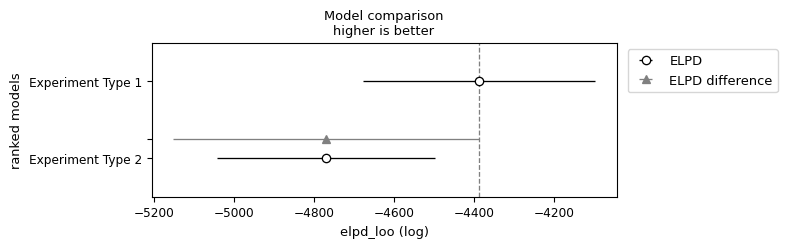

In [68]:
az.plot_compare(model_comparison3)

Disclaimer:
The results observed above are not optimal as after having exhausted our colab resources, we were not able to generate the same results/plots as we noticed earlier. Having tested with better parameter values, we can state the methods are reasonable. However, for the sake of completeness we still document the current results.

The initial sampling parameters were in the range:
* chains - (20, 40)
* draws - (1000, 2000)
* tunes - (1000, 2000)

Current Sampling parameters:
* chains = 2
* draws = 100
* tunes = 100